# `Материалы кафедры ММП факультета ВМК МГУ. Введение в глубокое обучение.`

# `Лекция 07. Рекуррентные нейронные сети`

##### `Основную часть материалов составил Феоктистов Дмитрий на основе материалов Хисматуллина Владимира (s02190724@gse.cs.msu.ru)`

##### `Часть про применение к NLP составил Алексеев Илья (@voorhs)`

#### `Москва, Весенний семестр 2025`


## `1. Основные модели работы с последовательностями`

<table><tr>
<td> 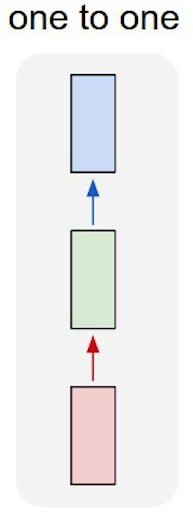 </td>
<td> 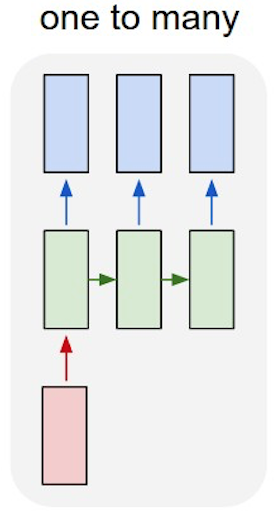 </td>
<td> 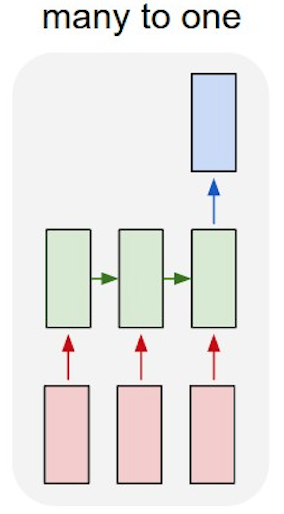 </td>
</tr></table>


<table><tr>
<td> 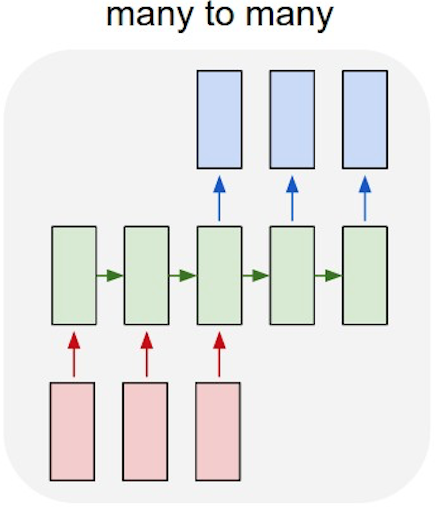 </td>
<td> 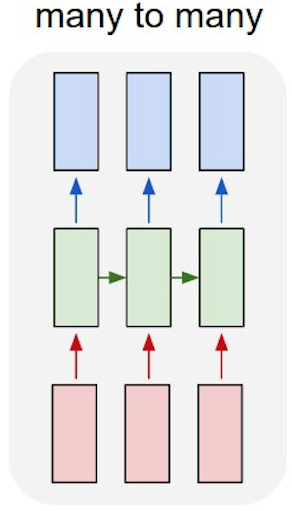 </td>
</tr></table>


1) One-to-one: На вход один объект и на выходе тоже (вырожденный случай)

2) One-to-many: На вход подается один объект, на выходе последовательность объектов

3) Many-to-one: На вход подается последовательность объектов, на выходе один объект

4) Many-to-many: На входе и выходе последовательности нефиксированной длины

###  `Приведите примеры задач каждого вида`

&nbsp;

<details>
  <summary>Нажмите, когда будете готовы увидеть ответ</summary>
    <ol>
      <li>One-to-one: классификация картинок</li>
      <li>One-to-many: создание подписей к картинкам (image captioning)</li>
      <li>Many-to-one: классификация текстов или видео</li>
      <li>Many-to-many: машинный перевод, суммаризация</li>
    </ol>
</details>

###  `Какие основные свойства RNN?`


&nbsp;

<details>
  <summary>Нажмите, когда будете готовы увидеть ответ</summary>
    <ol>
      <li>Parameter sharing. Если в картинках такое хорошо работает, то хотелось бы что-то такое и тут</li>
      <li>Возможность обрабатывать последовательности любой длины</li>
      <li>Обогащение векторных представлений токенов информацией об окружающих токена</li>
    </ol>
</details>

### `Рекуррентные нейронные сети`

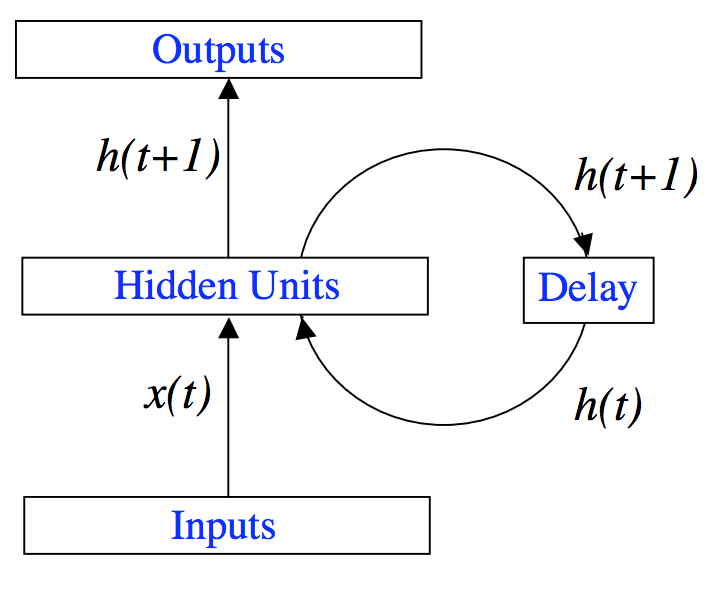

Простая рекуррентная нейронная сеть (сеть Элмана):

$$
\begin{split}
h_{t} & =  \text{tanh}(W_{ih}^{T} \cdot X_{t} + W_{hh}^{T}\cdot h_{t-1} +b_{h})\\
    \hat{y}_{t} &= \text{softmax}(W_{oh}^{T}\cdot h_{t} + b_{y})
\end{split}
$$

где $W_{ih}$, $W_{hh}$ и $W_{oh}$ - матрицы весов соответственно для входа, скрытых состояний и выхода.

#### `Небольшой трюк, повышающий эффективность реализации модели Элмана`

Пусть $n_{neurons}$ - размерность скрытого состояния (количество нейронов в скрытом состоянии).

1. Матрицы весов $W_{ih}$ и $W_{hh}$ можно конкатенировать вертикально и получить $W$ размера $(n_{inputs} +  n_{neurons}) \times  n_{neurons}$.
2. Обозначим конкатенацию входа  $X_{t}$ и скрытого состояния $h_{t-1}$,размера $m \times (n_{inputs} + n_{neurons})$ как $[X_{t}, h_{t-1}]$.

Тогда новое состояние  можно вычислить по обновлённой формуле:
$$
\begin{split}
    h_{t} & = \text{tanh}(X_{t}\cdot W_{ih} + h_{t-1}\cdot  W_{hh} + b_{h})\\
    &=\text{tanh}( [X_{t}, h_{t-1}] \cdot W + b_{h})\\
\end{split}
$$


Резюмируем:

1. $X_{t}$ размера $m \times n_{inputs}$ матрица с проекциями всех последовательностей в момент $t$.
2. $h_{t-1}$ размера $m \times n_{neurons}$ матрица с скрытыми состояниями для **каждого** объекта в батче в момент $t$.
3. $W_{ih}$ размера $n_{inputs} \times n_{neurons}$ матрица весов между входом и текущим скрытым слоем.
4. $W_{hh}$ размера $n_{neurons} \times n_{neurons}$ матрица весов между прошлым и текущим скрытыми слоями.
5. $W_{oh}$ размера $n_{neurons} \times n_{output}$ матрица весов между текущим скрытым состоянием и выходом.
6. $b_{h}$ вектор размера $n_{neurons}$ смещение для обновление скрытого слоя.
7. $b_{o}$ вектор размера $n_{output}$ смещение для вычисления выхода модели.
8. $y_{t}$ размера $m \times n_{output}$ матрица выхода модели в момент $t$ для **каждого** объекта в батче.


### `Развертывание рекуррентной сети`



<div>
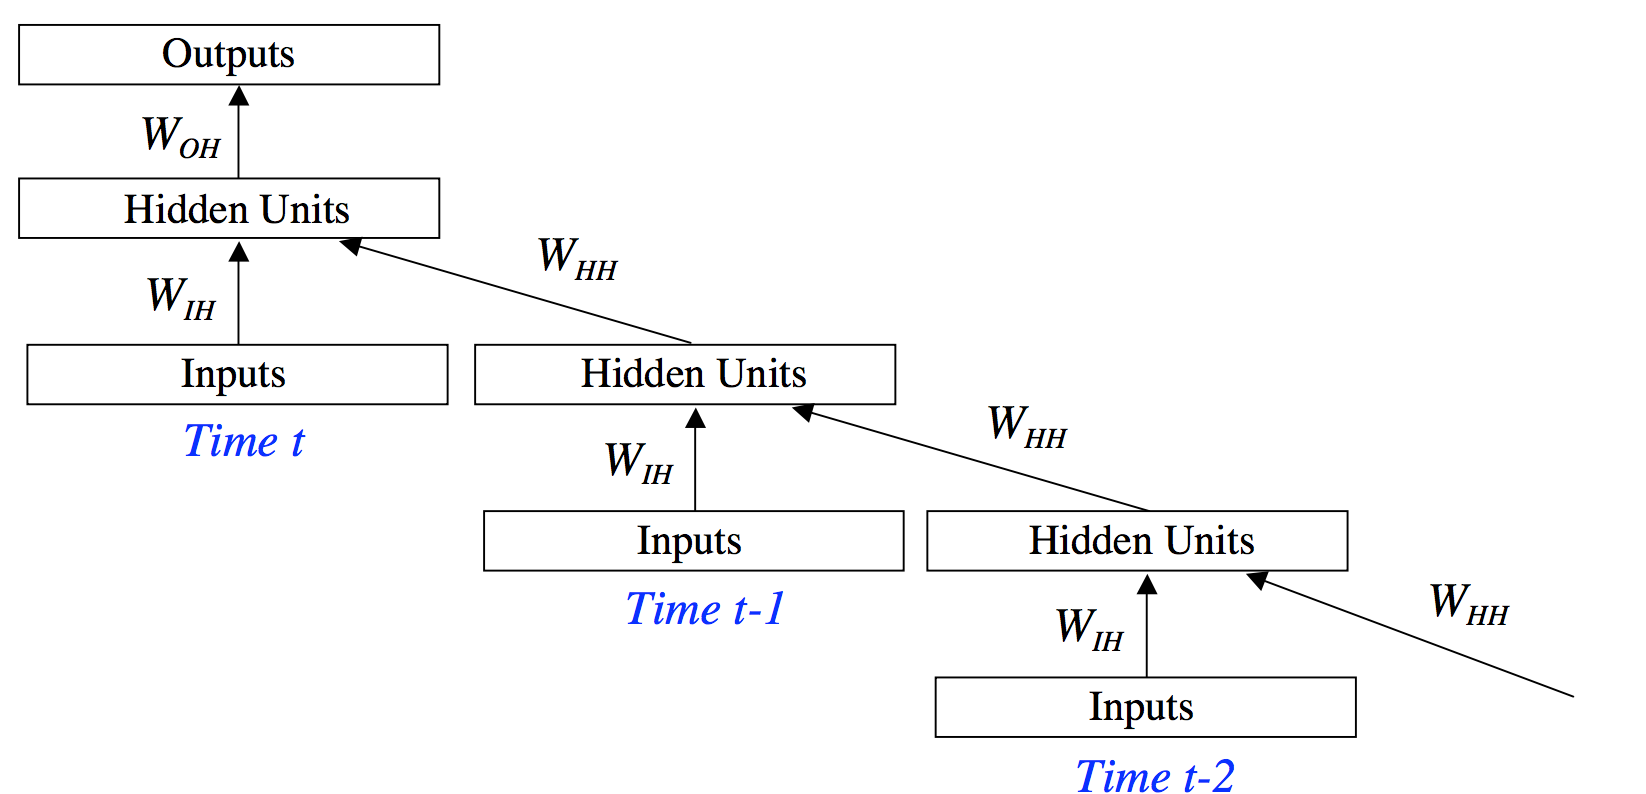
</div>

Используя введенную ранее рекурсивную формулу опишем состояние модели в момент времени $t$:
$$
\begin{align}
h_t &= f_{h} (X_{t}, f_{h} (X_{t-1}, f_{h} (X_{t-2}, ...(X_{2}, f_{h} (X_{1}, h_{0}) ))) &\leftarrow \text{  в общем случае  }
\\
h_t &=\text{tanh}(W_{ih}^{T} \cdot X_{t} + W_{hh}^{T}\cdot \text{tanh}(... (\text{tanh}(W_{ih}^{T} \cdot X_{1} + W_{hh}^{T}\cdot h_{1} +b_{h}) +b_{h}))) &\leftarrow \text{  для модели Элмана  }
\end{align}
$$

### `Как бороться с взрывом градиентов?`

Помимо использования LSTM и GRU (--- т.н. gated архитектуры), полезный трюк это gradient clipping.

Обычный шаг обучения:
1. семплируем батч данных: $B\sim \text{Data}$
2. проход вперед: $\mathcal{L}:=\text{NN}_\theta(B)$
3. проход назад: $g:=\nabla_\theta \mathcal{L}$
4. шаг оптимизации: $\theta_\text{new}:=\theta_\text{old}-\eta g$

Объект $g$ --- это вектор, в который собрали градиенты всех весов сети. Обрезка градиента заключается в модификации градиента $g$ следующим образом:
$$
\hat g := g \cdot \min\left(1,{t\over\|g\|}\right),
$$

где $t$ --- максимальное значение нормы градиента, которое мы допускаем. Если норма градиента на данном батче оказалась больше положенного, то градиенты всех параметров сети масштабируются таким образом, чтобы вектор $g$ имел норму $t$.

&nbsp;

<details>
  <summary>Как вы думаете, почему бы просто не применить покомпонентный `torch.clamp`?</summary>
    Тогда изменится направление градиента.
</details>

### `Как бороться с затуханием градиентов?`


&nbsp;

<details>
  <summary>Нажмите, когда будете готовы увидеть ответ</summary>
    <ol>
        <li>Оптимизация с помощью методов с инерцией и надежда на то, что мы из-за нее проскочим место, где градиенты тухнут</li>
        <li>Использование функций активации с единичными производными (ReLU, Hardshrink)</li>
        <li>Ортогональная инициализация (попытка удержания единичной нормы за счёт инициализации).</li>
        <li><b style="color: green"> Gated models - наверное, самый эффективный, простой и популярный способ. Использование сетей специального вида (LSTM, GRU).</b> </li>
    </ol>
    Если в случае взрывов градиентов у нас есть универсальный способ борьбы - клиппинг, то для затухания такого нет, и пункт про архитектуру становится еще важнее
</details>

### ` Модель LSTM `


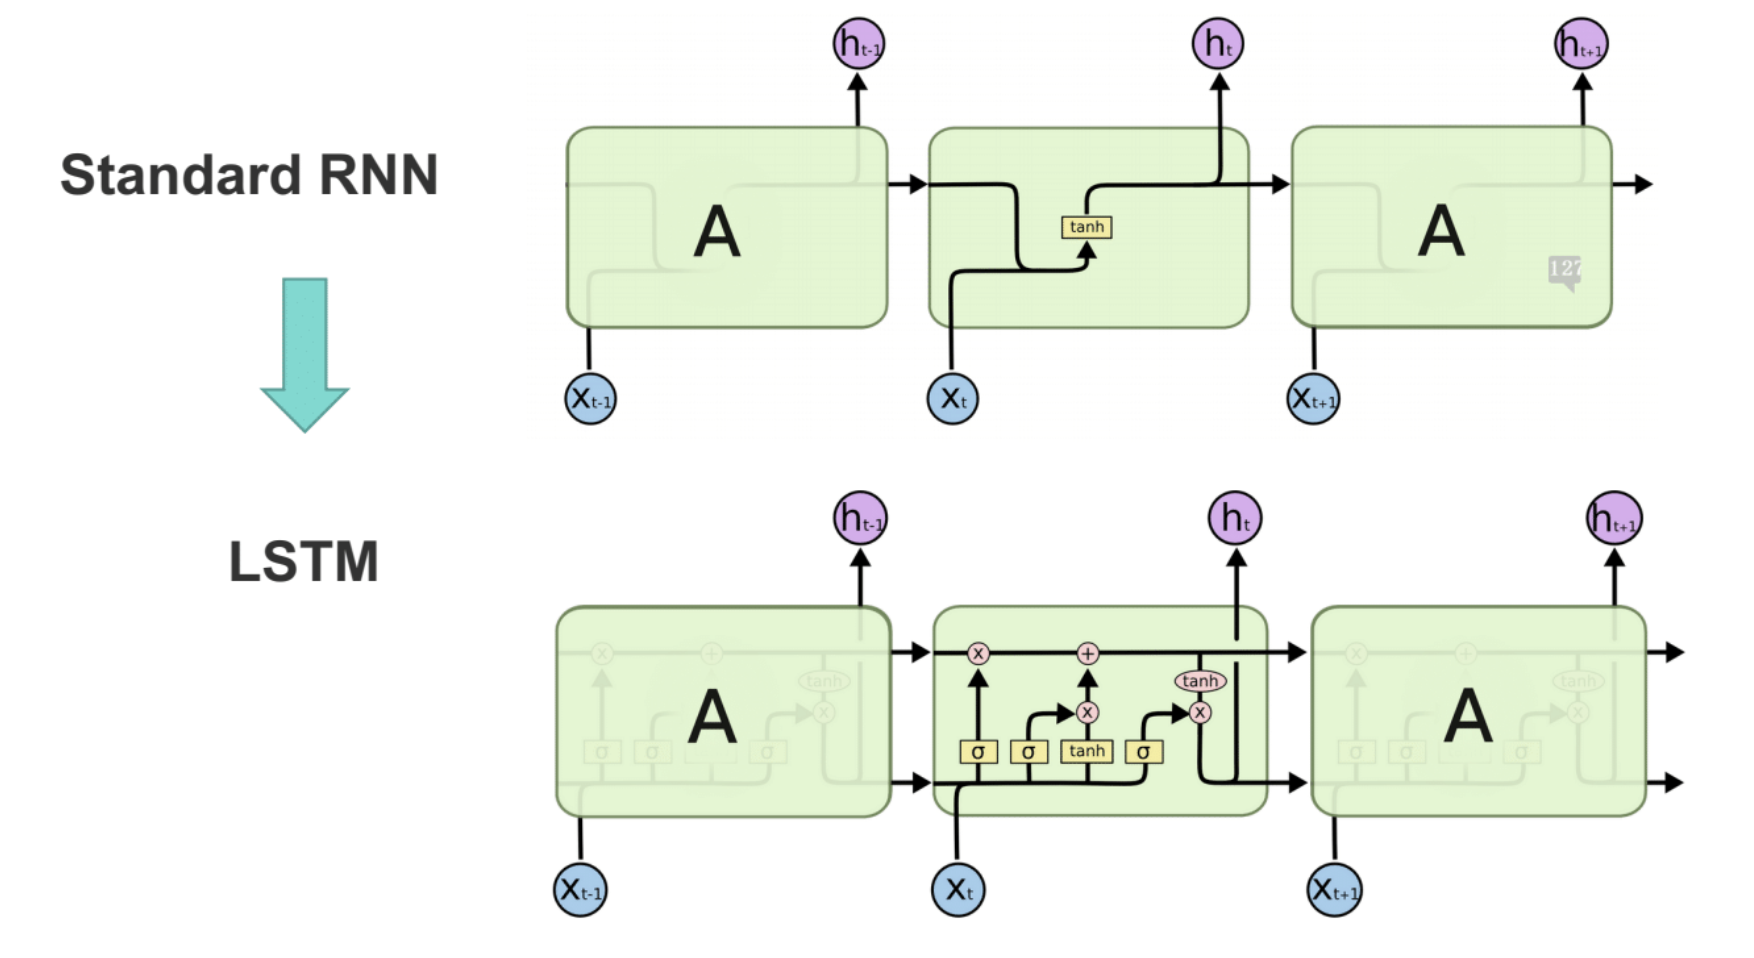
</div>




$$
\text{Точные формулы}\\
\begin{align}
\text{forget } f_t &= \text{Sigmoid}(W_{f} x_t + U_{f} h_{t-1} + b_f)  \\
\text{input  } i_t &= \text{Sigmoid}((W_{i} x_t + U_{i} h_{t-1} + b_i) \\
\text{output }o_t &= \text{Sigmoid}(W_{o} x_t + U_{o} h_{t-1} + b_o) \\
\text{candiadate  }\tilde{C}_t &= \text{Tanh}(W_{c} x_t + U_{c} h_{t-1} + b_c) \\
C_t &= f_t \odot C_{t-1} + i_t \odot \tilde{C}_t \\
h_t &= o_t \odot \text{Tanh}(C_t)
\end{align}
$$


### `Разбор смысловой нагрузки гейтов`


***1. Forget gate***

&nbsp;
<details>
  <summary>Нажмите, когда будете готовы увидеть ответ</summary>
Допустим, на вход модели поступает текст. Она должна следить за семантической структурой, а потому когда слова меняются с единственного числа на множественные, то модель должна забыть часть прошлого контекста. Представим, что некоторые координаты $1,...,m$ из представления $C_t$ отвечают за число и пол субъекта части предложения.

Рассмотрим предложение "Гости съели пироги - постарался наврать Вова". В первой части подлежащее множественного числа, а во второй части единственного.

В тот момент, когда пришло слово 'постарался', мы понимаем, что речь идёт уже о другом субъекте. Поэтому $f_t$ будет примерно равна 0 для координат $C$ отвечающих за пол, число, так как их нужно забыть.
</details>


***2. Candidate gate***

&nbsp;
<details>
  <summary>Нажмите, когда будете готовы увидеть ответ</summary>
Данный gate отвечает за то, какая новая информация будет внесена в длинную память. В прошлом примере для слова 'постарался' он будет содержать информацию о новом поле и числе существительного. Такую же информацию он будет содержать и для остальных слов предложения.

Важное отличие от остальных gate'ов! Функция Tanh используется, чтобы получать значения в диапозоне $[-1,1]$.
</details>


***3. Input (update) gate***

&nbsp;
<details>
  <summary>Нажмите, когда будете готовы увидеть ответ</summary>
Данный gate отвечает за то, будет ли внесена информация из Candidate в $C_t$. Например, на слове 'пироги' нам не нужно обновлять число субъекта, поэтому $i_t \approx 0$. Но на слове 'постарался' необходимо зафиксировать изменения: $i_t \approx 1$.
</details>


***4. Output gate***

&nbsp;
<details>
  <summary>Нажмите, когда будете готовы увидеть ответ</summary>
В отличие от остальных gate'ов, данный не влияет на $C_t$, но меняет $h_t$. Регулирует, что должно остаться в короткой памяти и пойти на выход. Например, если среди координат $1,...,m$  в $C_t$  отвечающих за число текущего субъекта также хранится осреднённая информация о предыдущих субъектах, то данный gate должен её удалить.
</details>

### ` Модель GRU `

<img src='http://vbystricky.ru/images/2021-05/gru.svg'>


$$
\text{Точные формулы}\\
\begin{align}
\text{reset } r_t &= \text{Sigmoid}(W_{ir} x_t + W_{hr} h_{t-1} + b_r)  \\
\text{update  } z_t &= \text{Sigmoid}((W_{iz} x_t + W_{hz} h_{t-1} + b_z) \\
\text{new } n_t &= \text{tanh}(W_{in} x_t + b_{in} + r_t \odot (W_{hn} h_{t-1} + b_{hn})) \\
h_t &= (1 - z_t) \odot n_t + z_t \odot h_{t-1}
\end{align}
$$


В отличие от LSTM, GRU состоит только из трех гейтов и не поддерживает глобальный контекст, всю необходимую информацию мы содержим в скрытом состоянии. Сыграем в угадайку. Попробуйте догадаться, что делает каждый из гейтов, исходя из формул и знаний LSTM.

&nbsp;
<details>
  <summary>Нажмите, когда будете готовы увидеть ответ</summary>
  <ol>
    <li>Update Gate (z): Он определяет, в каком виде прошлую информацию надо передать далее. По сути является аналогом output gate в LSTM</li>
    <li>Reset Gate (r): определяет, какую часть прошлых знаний следует забыть. По сути действует аналогично комбинации input gate и forget gate в LSTM.</li>
    <li>New Gate (n): часто не выделяют, как отдельный гейт, а объединяют с Update Gate, что следует из названия. Здесь происходит добавление новой информации к старой и определение того, что мы хотим передать далее с учетом этих знаний.</li>
   </ol>
</details>  


GRU очень похожа на LSTM, но использует меньше параметров из-за чего ее обучение дешевле. Эти две архитектуры являются самыми популярными среди RNN

## `2. Обработка последовательностей в pytorch`

Теперь посмотрим на практике то, что обсуждалось ранее. А именно поведение градиентов и методов борьбы с их плохим поведением

#### Задача: даны x, y, z координаты частей рук человека.

$ X = (\mathbb{x_1}, \mathbb{x_1}, \dots, \mathbb{x_L})\text{ - последовательность фиксированной длины из многомерных векторов,} \\ \mathbb{x} = (x_{1,1}, x_{1,2}, x_{1,3}, \dots, x_{8,1}, x_{8,2}, x_{8,3}) \in \mathbb{R}^{24} \text{- проекция последовательности в некоторый момент времени}$

#### Классифицировать жесты, выполняемые человеком. [(Датасет NATOPS)](http://www.timeseriesclassification.com/description.php?Dataset=NATOPS)


Данная задача - классификация временного ряда.

Тип 'many to one' (но можно успешно решать свёртками / полносвязными сетями как one to one, так как длина ряда фиксирована).

В данной простой задаче длины рядов как раз совпадают для всех объектов и равны 51.

![example.gif](attachment:example.gif)

In [1]:
! wget https://www.timeseriesclassification.com/aeon-toolkit/NATOPS.zip
! unzip NATOPS -d NATOPS
! rm NATOPS.zip

--2025-03-18 07:36:53--  https://www.timeseriesclassification.com/aeon-toolkit/NATOPS.zip
Resolving www.timeseriesclassification.com (www.timeseriesclassification.com)... 212.78.75.243
Connecting to www.timeseriesclassification.com (www.timeseriesclassification.com)|212.78.75.243|:443... connected.
HTTP request sent, awaiting response... 200 
Length: 3479750 (3.3M) [application/zip]
Saving to: ‘NATOPS.zip’

NATOPS.zip          100%[===================>]   3.32M  2.71MB/s    in 1.2s    

2025-03-18 07:36:55 (2.71 MB/s) - ‘NATOPS.zip’ saved [3479750/3479750]

Archive:  NATOPS.zip
  inflating: NATOPS/NATOPS.jpg       
  inflating: NATOPS/NATOPS.txt       
  inflating: NATOPS/NATOPS_TEST.arff  
  inflating: NATOPS/NATOPS_TEST.ts   
  inflating: NATOPS/NATOPS_TRAIN.arff  
  inflating: NATOPS/NATOPS_TRAIN.ts  


In [3]:
! pip install sktime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.9/36.9 MB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.5/141.5 kB 14.2 MB/s eta 0:00:00


In [4]:
from collections import defaultdict
import pandas as pd
import numpy as np
import scipy

import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms as T
from torch.optim.lr_scheduler import StepLR

import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

import sktime
from sktime.datasets import load_from_tsfile_to_dataframe
from torch.utils.data import Dataset, DataLoader

from tqdm.notebook import tqdm
import random

import gc

In [5]:
%config InlineBackend.figure_formats = ['svg']

In [6]:
def set_global_seed(seed: int) -> None:
    """
    Set global seed for reproducibility.
    """

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    random.seed(seed)
    np.random.seed(seed)

set_global_seed(42)

In [7]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(42)

Для работы с данными в pytorch следует писать свой Dataset

В данном случае исходные данные имеют тип sktime. Используя соответствующую библиотеку их можно отразить в pandas.DataFrame. Оттуда их нужно перевести в numpy или сразу torch.

Особенность обработки - метки могут быть строками, поэтому для перевода их в числа нужно хранить словарь, который нужно 'обучить' на основной части выборки и использовать в тестовой.

In [8]:
class Sktime_Series_Сlassification_Dataset(Dataset):
    def __init__(self, data_path, label_dict=None, transforms=None, pad_len=None):
        """
        :data_path: Строка к файлу с данными в формате sktime
        :label_dict: Словарь преобразования исходных меток (строк) в индексы
        :transforms: Возможные аугментации данных
        :pad_len - length of padding to apply when the length is not fixed
        """
        super().__init__()

        # Данные приходят размера N x M x L
        _x, _y = load_from_tsfile_to_dataframe(data_path)

        self.M = _x.shape[1]
        self.series_len =  _x[_x.columns[0]].iloc[0].shape[0]

        # Если нужно привести все ряды к одинаковой длине - добиваем до заданного размера нулями
        if pad_len is not None:
            self.X = [[np.hstack((np.array(_x.iloc[object_ind][column]), np.zeros(pad_len -_x.iloc[object_ind][column].shape[0])))
                    for column in _x.columns] for object_ind in range(_x.shape[0])]
        else:
            self.X = [[np.array(_x.iloc[object_ind][column]) for column in _x.columns] for object_ind in range(_x.shape[0])]
        self.X = np.array(self.X)

        # Создаём словарь для обработки классов
        if label_dict is None:
            self.label_dict = {}
            for i, word in enumerate(np.unique(_y)):
                self.label_dict[word] = i
            print('Размерность обучающей выборки {0} x {1} x {2} (Количество объектов x размерность x длина)'.format(*self.X.shape))
            print('Всего {0} классов'.format(len(self.label_dict.keys())))
        else:
            # В тестовый датасет передадим готовый словарь
            self.label_dict = label_dict

        # Кодируем вектор таргетов как (-1,)
        self.y = np.zeros((_y.shape[0]), int)
        for i, word in enumerate(_y):
            self.y[i] = self.label_dict[word]

        self.transforms = transforms

    def __getitem__(self, idx):
        """
        :idx: индекс объекта из выборки
        """

        object_ = {'series':self.X[idx], 'target':self.y[idx]}

        # Если есть преобразования - применяем
        if self.transforms is not None:
            for transform in self.transforms:
                object_ = transform(object_)

        return object_

    def __len__(self):
        """
        :return int: number of objects in dataset
        """
        return self.X.shape[0]

Для применения трансформаций выборки необходимо реализовать специальный декоратор.

In [9]:
def basic_series_transform(transform):
    """
    Применяет преобразование transform к временному ряду.
    Метку при этом не трогает.
    """
    def wrapper(object, *args, **kwargs):
        object['series'] = transform(object['series'], *args, **kwargs)
        return object
    return wrapper

class Jittering(object):
    """
    Добавляет нормальный шум в ряд.
    """
    def __init__(self, sigma):
        self.sigma = sigma

    def __call__(self, object):
        Noise = np.random.normal(loc=0, scale=self.sigma, size=object.shape)
        return object + Noise

<div class="alert alert-danger">

Нами выбрана и зафиксирована концепция 'Batch first'. Т.е. классы реализованы таким образом, что в сеть передаваться будет 'объект' размера $ N \times L \times M$.

В д/з будет другой вариант, в котором 'объект' будет размера $ L \times N \times M$.

При обработке временных последовательностей свёртками также популярно предстваление $ N \times M \times L$.
</div>

<div class="alert alert-danger">

Если ваша модель рекуррентной сети работает ( не выдаёт ошибку ), но не обучается ( качество скачет около минимума ) - вполне возможно, что вы передали данные неправильного вида.

Например в сеть, которая принимает батчи размера $ N \times L \times M$ передали данные вида $ L \times N \times M$.
</div>

<div class="alert alert-danger">

В данном, упрощённом случае длина $L$ одинакова для всех батчей. Более общий случай будет разобран на следующем занятии.
</div>


In [10]:
# Считываем всю информацию в заданные классы

name = 'NATOPS'
train_path = name +"/"+name +"_TRAIN.ts"
test_path = name +"/"+name +"_TEST.ts"

transforms =  [basic_series_transform(Jittering(0.1)), basic_series_transform(torch.Tensor)]

train_dataset = Sktime_Series_Сlassification_Dataset(train_path, transforms=transforms)
test_dataset = Sktime_Series_Сlassification_Dataset(test_path, train_dataset.label_dict)

test_loader = DataLoader(test_dataset, batch_size=10, shuffle=True, worker_init_fn=seed_worker, generator=g)
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True, worker_init_fn=seed_worker, generator=g)

Размерность обучающей выборки 180 x 24 x 51 (Количество объектов x размерность x длина)
Всего 6 классов


In [11]:
# Просто функции обучения модели
# Единственное отличие от стандартной парадигмы -
# при итерации по батчу не приходят пары (data, target),
# а словарь с соответствубщими полями

def evaluate(model, device, data_loader):
    """
    Возвращает качество и лосс модели на выборке
    """
    model.eval()
    loss = 0
    correct = 0
    length = 0

    with torch.no_grad():
        for batch_idx, batch in enumerate(data_loader):
            # Считываем данные из батча
            data, target = batch['series'].float().to(device), batch['target'].long().to(device)
            output = model(data)

            # Обновляем качество
            loss += F.nll_loss(output, target).item()
            pred = output.argmax(dim=1)
            correct += (pred == target).sum().item()
            length += batch['target'].shape[0]

    return loss / length, correct / length

def train(model, device, train_loader, test_loader, n_epoch, optimizer, scheduler,
          max_norm=None, track_gradient=False):
    """
    Обучение и оценивание качества на тесте одновременно

    max_norm - параметр gradient clipping. Если None, то не метод не используется.
    track_gradient - Если true, то оцениваем градиент на каждом батче.
    """
    train_history, test_history = {'loss':[], 'acc':[]}, {'loss':[], 'acc':[]}

    if track_gradient:
        grad_history = np.zeros((n_epoch, len(list(model.parameters()))))

    for epoch in tqdm(range(1, n_epoch + 1)):
        n_objects = 0
        model.train()
        for batch_idx, batch in enumerate(train_loader):
            # Считываем данные из батча
            data, target = batch['series'].float().to(device), batch['target'].long().to(device)

            # Делаем шаг по батчу
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()

            # Gradient clipping
            if max_norm is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_norm)

            # Если нужно - запоминаем норму градиента (отдельно по каждому параметру)
            if track_gradient:
                n_objects +=  data.shape[0]
                for i, p in enumerate(model.parameters()):
                    param_norm = p.grad.data.detach().norm(2)
                    grad_history[epoch-1][i] += param_norm.item() ** 2

            optimizer.step()
            scheduler.step()

        # Добавляем информацию в наш логгер
        loss, acc = evaluate(model, device, train_loader)
        train_history['loss'].append(loss), train_history['acc'].append(acc)
        loss, acc = evaluate(model, device, test_loader)
        test_history['loss'].append(loss), test_history['acc'].append(acc)

        if track_gradient:
            for i, p in enumerate(model.parameters()):
                grad_history[epoch-1][i] = (grad_history[epoch-1][i] / n_objects) ** 0.5


    if track_gradient:
        return train_history, test_history, grad_history
    return train_history, test_history

In [12]:
def delete_model(model: nn.Module):
    model.cpu()
    del model
    torch.cuda.empty_cache()
    gc.collect()

### `Построение рекуррентных моделей в pytorch`


In [13]:
class My_LSTM_Layer(nn.Module):
    """
    Класс - работа RNN с произвольной LSTM-ячейкой
    Единственное требование от этой ячейки - вход и выход как у LSTM

    Формат входа как в Batch first LSTM в pytorch - (N, L, M)
    """
    def __init__(self, input_size, hidden_size, rnn_cell, batch_first=False):
        super().__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.batch_first = batch_first

        # Класс реализующий ячейку LSTM
        self.rnn_cell = rnn_cell(self.input_size, self.hidden_size)

    def forward(self, X, state=None):
        """
        При прямом проходе необходимо получить скрытые состояния h_t
        для каждого момента времени. Это нужно, например для задач типа many to many
        """
        #  X размера N x L x M
        batch_size = X.shape[0]


        if state is None:
            # Очень важно! По умолчанию тензор будет на CPU и произойдёт ошибка.
            h_t = X.new_zeros((batch_size, self.hidden_size))
            c_t = X.new_zeros((batch_size, self.hidden_size))
        else:
            h_t, c_t = state

        output = []
        for t in range(X.shape[1]):
            if self.batch_first:
                h_t, c_t = self.rnn_cell(X[:,t,:], (h_t, c_t))
            else:
                h_t, c_t = self.rnn_cell(X[t,:,:], (h_t, c_t))
            # Сохраняем новый выход сети
            output.append(h_t)

        return torch.stack(output, dim=1), (h_t, c_t)

In [14]:
class Simple_RNN_Classifier(nn.Module):
    """
    Класс классификации с использованием произвольной RNN
    """
    def __init__(self, input_size, hidden_size, num_class, rnn,
                 activation=F.relu,  dropout_p=0.5):
        super().__init__()

        # 1. Тут могла быть ваша предобработка данных

        # Но в простой модели её нет

        # 2. Тут рекуррентная часть модели
        # Поступает уже инициализированная рекуррентная сеть
        self.rnn = rnn

        # 3. Тут классификатор
        # Классификатор - два полносвязных слоя с dropout
        self.classifier = nn.Sequential(
            nn.BatchNorm1d(hidden_size),
            nn.Linear(hidden_size, 40),
            nn.Dropout(dropout_p / 2.0),
            activation, nn.Linear(40, num_class),
            nn.Dropout(dropout_p)
        )

    def forward(self, input):
        # Наш ряд из Dataloader имеет представление (N, M, T)
        # Размер входа в LSTM (N, T, M) -> нужна трансформация
        input = input.swapaxes(1, 2)

        # Проход по LSTM
        try:
            output, hidden = self.rnn(input)
        except Exception:
            output = self.rnn(input)
        # Возвращается h_t для всех моментов t = 1, 2,..., T
        # Размерность output (N, T, hidden)

        # Получаем h_T
        output = output[:, -1, :]

        # Проводим классификацию
        output = self.classifier(output)
        output = F.log_softmax(output, dim=1)
        return output

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda', index=0)

# `3. Сравнение различных подходов в RNN`

В pytorch доступно всего 3 модели RNN:
1. Простая RNN (Элмана)
2. LSTM
3. GRU

Посмотрим как обучаются различные модели на нашей задаче.  
А именно, рассмотрим графики качества, функции потерь и средней по выборке нормы градиента
$\dfrac{\partial L_{t+1}}{\partial W_{hh}}, \dfrac{\partial L_{t+1}}{\partial W_{ih}}$.

Определим среднюю норму градиента по выборке для нашей many-to-one задачи:

Пусть выборка разбита на $k$ одинаковых по размеру батчей $(\hat{X}_1, ..., \hat{X}_k)$. Тогда средняя норма градиента по параметру $\omega$ равняется

$$
\sqrt{\frac{1}{k}\sum_{n=1}^k \left\lVert\frac{\partial L}{\partial W_{hh}}\right\rVert_n^2}
$$

Здесь $\frac{\partial L}{\partial W_{hh}}_n$ - оценка градиента по n-ому батчу.

In [15]:
def get_exps(model, optimizer, scheduler, title, num_epoch=200, max_norm=None):
    # Проводим обучение и строим графики loss, acccuracy
    train_history, test_history, grad_history = train(model, device, train_loader, test_loader,
                    num_epoch, optimizer, scheduler, max_norm, track_gradient=True)
    plt.subplots(1, 2,figsize=(14,5))
    plt.suptitle(title)
    plt.subplot(1, 2, 1)
    plt.plot(train_history['loss'])
    plt.plot(test_history['loss'])
    plt.xlabel('Эпоха')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Test'])
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(train_history['acc'][:])
    plt.plot(test_history['acc'][:])
    plt.xlabel('Эпоха')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Test'])
    plt.grid()
    plt.show()
    return train_history, test_history, grad_history

### `Handmade LSTM`

В модели 50400 + 4486 параметров


  0%|          | 0/200 [00:00<?, ?it/s]

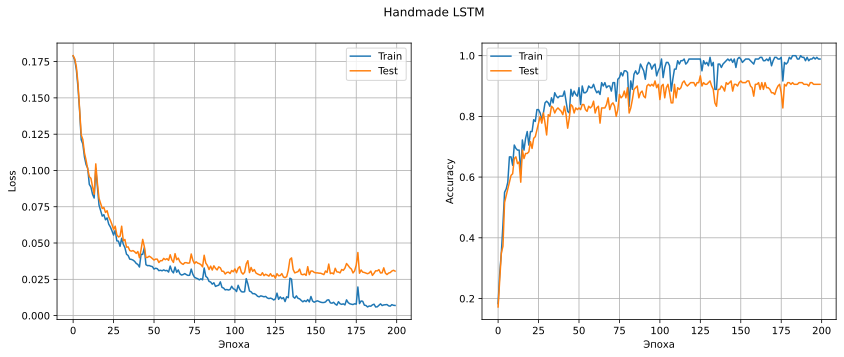

In [16]:
input_size = 24
hidden_size = 100

lstm = My_LSTM_Layer(input_size, hidden_size, nn.LSTMCell, batch_first=True)
model = Simple_RNN_Classifier(
    input_size=input_size,
    hidden_size=hidden_size,
    num_class=6,
    rnn=lstm,
    activation=nn.ReLU()
).to(device).float()
x, y = sum(p.numel() for p in lstm.parameters()), sum(p.numel() for p in model.parameters())
print(f'В модели {x} + {y - x} параметров')

optimizer = optim.Adam(model.parameters(), lr=5e-4)
scheduler = StepLR(optimizer, step_size=100, gamma=0.9)

_, _, grad_history_HM_LSTM = get_exps(model, optimizer, scheduler, 'Handmade LSTM', 200)

In [17]:
# Посмотрим на то, какие параметры есть в модели
for i, p in enumerate(model.parameters()):
    print(f'Параметр {i}, размер {p.shape}')

Параметр 0, размер torch.Size([400, 24])
Параметр 1, размер torch.Size([400, 100])
Параметр 2, размер torch.Size([400])
Параметр 3, размер torch.Size([400])
Параметр 4, размер torch.Size([100])
Параметр 5, размер torch.Size([100])
Параметр 6, размер torch.Size([40, 100])
Параметр 7, размер torch.Size([40])
Параметр 8, размер torch.Size([6, 40])
Параметр 9, размер torch.Size([6])


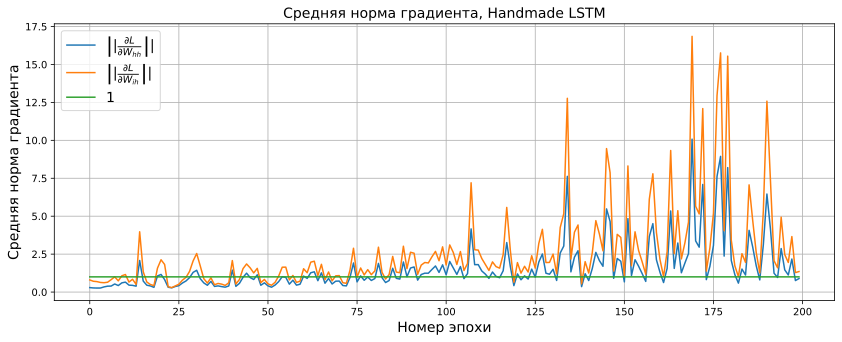

In [18]:
def plot_grads (grad, name):
    plt.figure(figsize=(14, 5))
    plt.title(r'Средняя норма градиента, ' + name, fontsize=14)
    plt.xlabel('Номер эпохи', fontsize=14)
    plt.ylabel('Средняя норма градиента', fontsize=14)
    plt.plot(grad[:, 1])
    plt.plot(grad[:, 0])
    plt.plot(np.ones(200))

    plt.legend([r'$\left||\frac{\partial L}{\partial W_{hh}}\right||$',
                r'$\left||\frac{\partial L}{\partial W_{ih}}\right||$', r'$1$'], fontsize=14)
    plt.grid()
    plt.show()
plot_grads(grad_history_HM_LSTM, 'Handmade LSTM')

In [19]:
delete_model(model)
delete_model(lstm)

### `LSTM`

В модели 50400 + 4486 параметров


  0%|          | 0/200 [00:00<?, ?it/s]

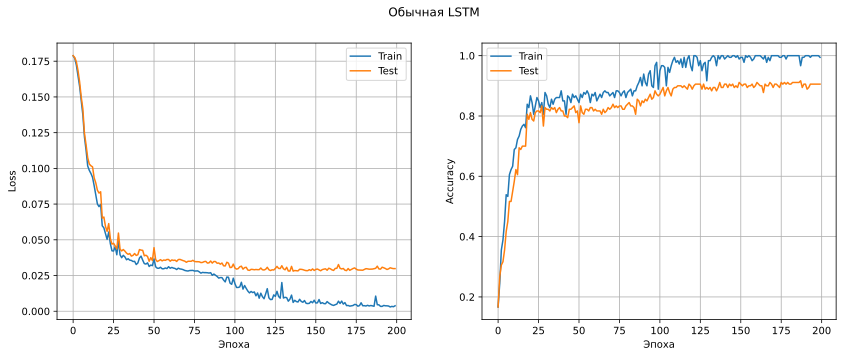

In [20]:
input_size = 24
hidden_size = 100

lstm = nn.LSTM(24, 100, batch_first=True)
model = Simple_RNN_Classifier(24, 100, 6, lstm, nn.ReLU()).to(device).float()
x, y = sum(p.numel() for p in lstm.parameters()), sum(p.numel() for p in model.parameters())
print(f'В модели {x} + {y - x} параметров')

optimizer = optim.Adam(model.parameters(), lr=5e-4)
scheduler = StepLR(optimizer, step_size=100, gamma=0.9)

_, _, grad_history_LSTM = get_exps(model, optimizer, scheduler, 'Обычная LSTM', 200)

In [21]:
# Посмотрим на то, какие параметры есть в модели
for i, p in enumerate(model.parameters()):
    print(f'Параметр {i}, размер {p.shape}')

Параметр 0, размер torch.Size([400, 24])
Параметр 1, размер torch.Size([400, 100])
Параметр 2, размер torch.Size([400])
Параметр 3, размер torch.Size([400])
Параметр 4, размер torch.Size([100])
Параметр 5, размер torch.Size([100])
Параметр 6, размер torch.Size([40, 100])
Параметр 7, размер torch.Size([40])
Параметр 8, размер torch.Size([6, 40])
Параметр 9, размер torch.Size([6])


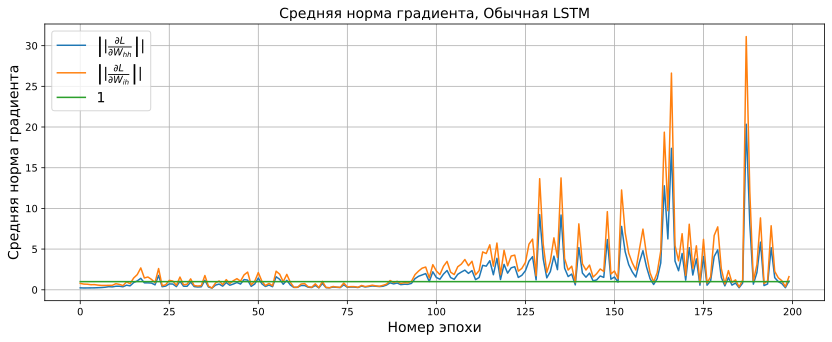

In [22]:
plot_grads(grad_history_LSTM,  'Обычная LSTM')

In [23]:
delete_model(model)
delete_model(lstm)

### `GRU`

В модели 37800 + 4486 параметров


  0%|          | 0/200 [00:00<?, ?it/s]

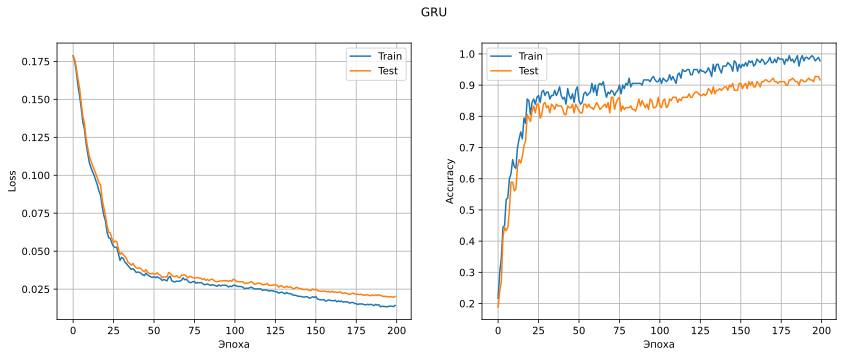

In [24]:
input_size = 24
hidden_size = 100

gru = nn.GRU(24, 100, batch_first=True)
model = Simple_RNN_Classifier(24, 100, 6, gru, nn.ReLU()).to(device).float()
x, y = sum(p.numel() for p in gru.parameters()), sum(p.numel() for p in model.parameters())
print(f'В модели {x} + {y - x} параметров')

optimizer = optim.Adam(model.parameters(), lr=5e-4)
scheduler = StepLR(optimizer, step_size=100, gamma=0.9)

_, _, grad_history_GRU = get_exps(model, optimizer, scheduler, 'GRU', 200)

In [25]:
# Посмотрим на то, какие параметры есть в модели
for i, p in enumerate(model.parameters()):
    print(f'Параметр {i}, размер {p.shape}')

Параметр 0, размер torch.Size([300, 24])
Параметр 1, размер torch.Size([300, 100])
Параметр 2, размер torch.Size([300])
Параметр 3, размер torch.Size([300])
Параметр 4, размер torch.Size([100])
Параметр 5, размер torch.Size([100])
Параметр 6, размер torch.Size([40, 100])
Параметр 7, размер torch.Size([40])
Параметр 8, размер torch.Size([6, 40])
Параметр 9, размер torch.Size([6])


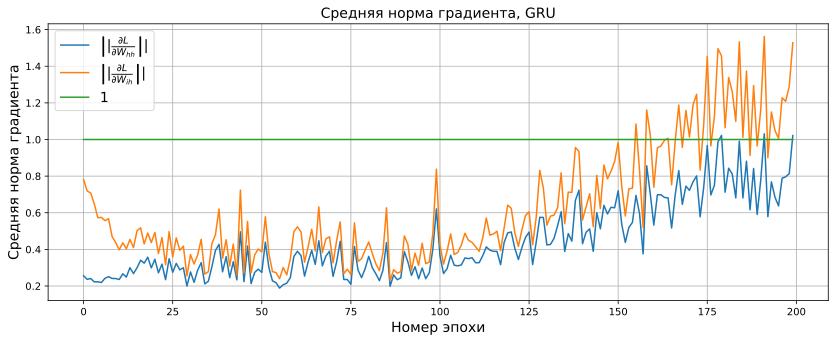

In [26]:
plot_grads(grad_history_GRU,  'GRU')

In [27]:
delete_model(model)
delete_model(gru)

### `RNN Элмана`

Попытаемся обучить RNN с размерностью скрытого предстваления 230. В этом случае модель имеет примерно то же число параметров, что и LSTM с скрытой размерностью 100.

В модели 58880 + 9946 параметров


  0%|          | 0/200 [00:00<?, ?it/s]

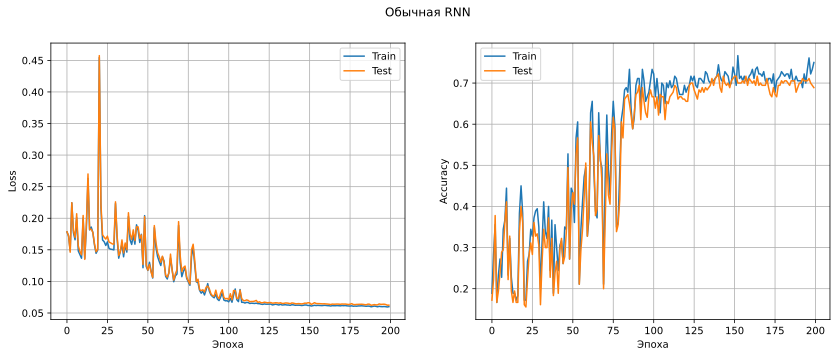

In [28]:
rnn = nn.RNN(24, 230, batch_first=True)
model = Simple_RNN_Classifier(24, 230, 6, rnn, nn.ReLU()).to(device).float()

x, y = sum(p.numel() for p in rnn.parameters()), sum(p.numel() for p in model.parameters())
print(f'В модели {x} + {y - x} параметров')

optimizer = optim.Adam(model.parameters(), lr=5e-4)
scheduler = StepLR(optimizer, step_size=100, gamma=0.9)

_, _, grad_history_RNN = get_exps(model, optimizer, scheduler, 'Обычная RNN', num_epoch=200)

In [29]:
# Посмотрим на то, какие параметры есть в модели
for i, p in enumerate(model.parameters()):
    print(f'Параметр {i}, размер {p.shape}')

Параметр 0, размер torch.Size([230, 24])
Параметр 1, размер torch.Size([230, 230])
Параметр 2, размер torch.Size([230])
Параметр 3, размер torch.Size([230])
Параметр 4, размер torch.Size([230])
Параметр 5, размер torch.Size([230])
Параметр 6, размер torch.Size([40, 230])
Параметр 7, размер torch.Size([40])
Параметр 8, размер torch.Size([6, 40])
Параметр 9, размер torch.Size([6])


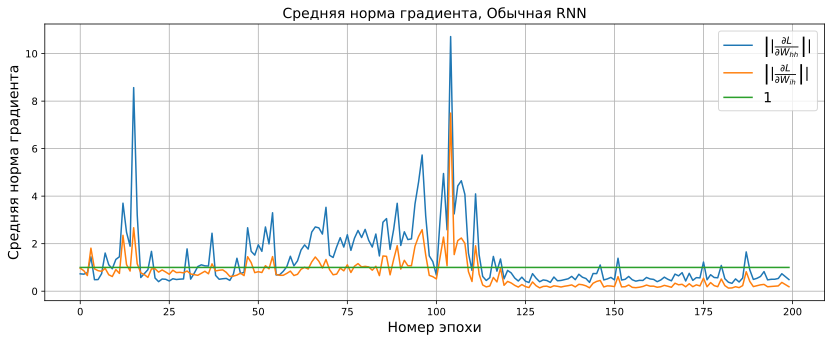

In [30]:
plot_grads(grad_history_RNN,  'Обычная RNN')

In [31]:
delete_model(model)
delete_model(rnn)

### `Облегчённая RNN`

Просто уменьшим размерность скрытого слоя

В модели 8480 + 3646 параметров


  0%|          | 0/200 [00:00<?, ?it/s]

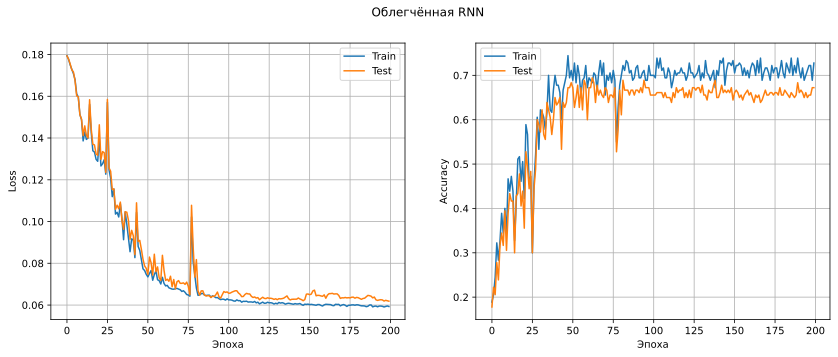

In [32]:
rnn = nn.RNN(24, 80, batch_first=True)
model = Simple_RNN_Classifier(24, 80, 6, rnn, nn.ReLU()).to(device).float()

x, y = sum(p.numel() for p in rnn.parameters()), sum(p.numel() for p in model.parameters())
print(f'В модели {x} + {y - x} параметров')

optimizer = optim.Adam(model.parameters(), lr=5e-4)
scheduler = StepLR(optimizer, step_size=100, gamma=0.9)

_, _, grad_history_RNN = get_exps(model, optimizer, scheduler, 'Облегчённая RNN', num_epoch=200)

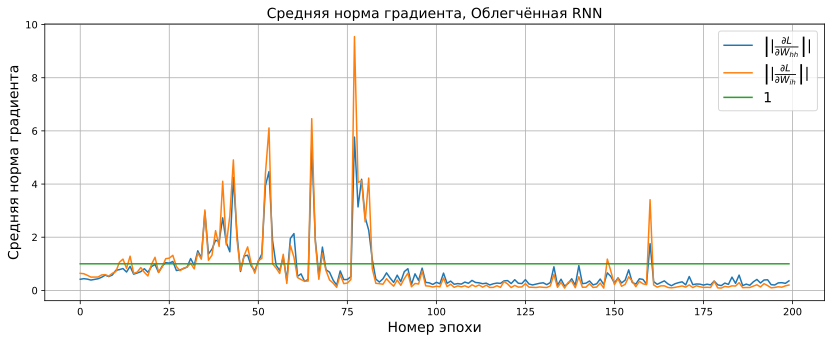

In [33]:
plot_grads(grad_history_RNN,  'Облегчённая RNN')

In [34]:
delete_model(model)
delete_model(rnn)

### `Gradient clipping`

В pytorch он применяется по батчам. Задаём коэф. $\theta$, и если $\left\lVert\dfrac{\partial L}{\partial W_{ih}}\right\rVert > \theta$, то он нормируется: $\dfrac{\partial L}{\partial W_{ih}} = \dfrac{\partial L}{\partial W_{ih}} \dfrac{\theta}{\left\lVert\frac{\partial L}{\partial W_{ih}}\right\rVert} $.

  0%|          | 0/200 [00:00<?, ?it/s]

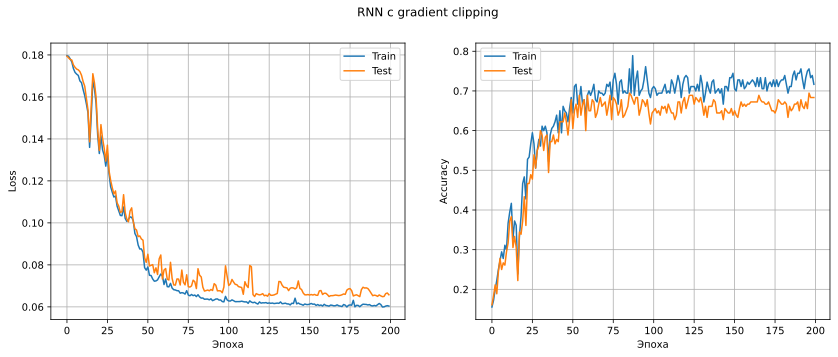

In [35]:
rnn = nn.RNN(24, 80, batch_first=True)
model = Simple_RNN_Classifier(24, 80, 6, rnn, nn.ReLU()).to(device).float()


optimizer = optim.Adam(model.parameters(), lr=5e-4)
scheduler = StepLR(optimizer, step_size=100, gamma=0.9)

_, _, grad_history_clip = get_exps(model, optimizer, scheduler, 'RNN с gradient clipping', num_epoch=200, max_norm=20)

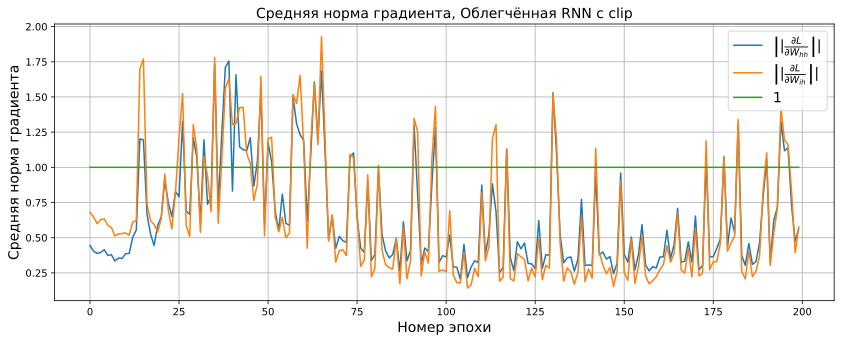

In [36]:
plot_grads(grad_history_clip, 'Облегчённая RNN с clip')

Как можно заметить, модель стала меньше флуктуировать, однако она все еще уступает другим моделям. Возможно дело в том, что градиент достаточно мал уже в самом начале или в том, что мы не решили проблему затухания в принципе. Попробуем исправить это ортогональной инициализацией

In [37]:
delete_model(model)
delete_model(rnn)

### `Gradient clipping + orthogonal initialization`

  0%|          | 0/200 [00:00<?, ?it/s]

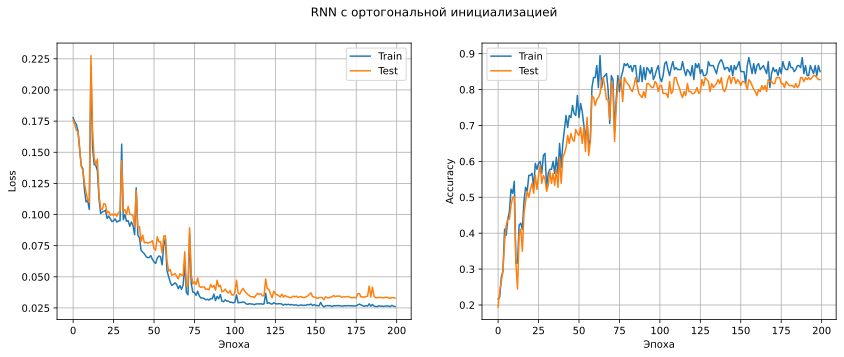

In [38]:
rnn = nn.RNN(24, 80, batch_first=True)
model = Simple_RNN_Classifier(24, 80, 6, rnn, nn.ReLU(), dropout_p=0.5).to(device).float()

# Ортогональная иницализация
for p in model.parameters():
    if len(p.shape) == 2:
        nn.init.orthogonal_(p)


optimizer = optim.Adam(model.parameters())
scheduler = StepLR(optimizer, step_size=100, gamma=0.9)

_, _, grad_history_init_clip = get_exps(model, optimizer, scheduler, 'RNN с ортогональной инициализацией',
                                        num_epoch=200, max_norm=10)

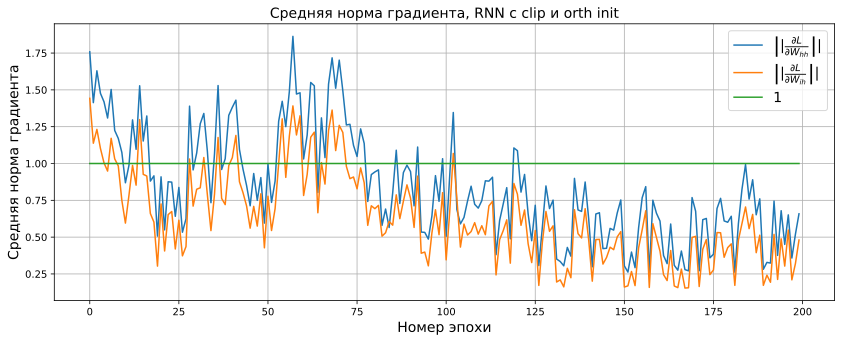

In [39]:
plot_grads(grad_history_init_clip, 'RNN с clip и orth init')

Как итог можно заявить, что модель классическая RNN модель обучается, но очень нестабильно. Что важно, качество на train и test примерно одинаковое, т.е. скачет общее качество модели. Применение специальных техник в данном случае дало существенное улучшение в качестве.

В то же время использование LSTM позволяет получить отличное качество на данном примере.

In [40]:
delete_model(model)
delete_model(rnn)

### `Bidirectional и Stacked LSTM`

Допустим вы хотите применить BiLSTM и сделать модель с 3 LSTM друг поверх друга. Тогда в базовой версии pytorch вы получите 6 LSTM - 3 пары. Более того, пусть input_size = 11,  hidden_size = 100, тогда все пары LSTM будет иметь матрицы $W_{hh}$ размера $400 \times 100$, выход будет иметь размерность $200$ (вектор размерности 100 от первой модели и 100 от второй). Однако матрицы $W_{ih}$ по парам будут иметь размеры $400 \times 11$, $400 \times 200$, $400 \times 200$ соответственно

В модели 342400 + 8686 параметров


  0%|          | 0/200 [00:00<?, ?it/s]

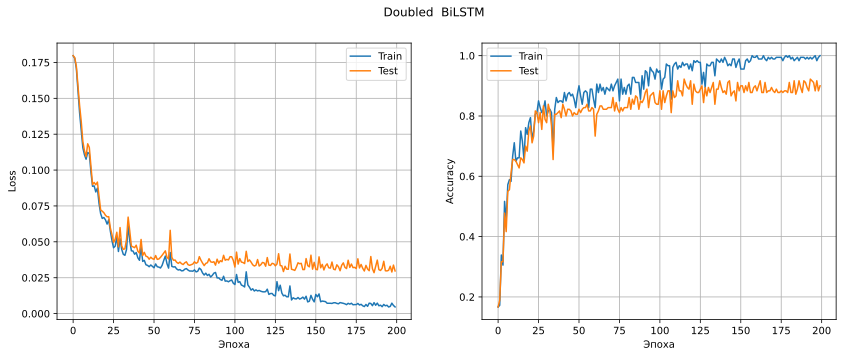

In [41]:
input_size = 24
hidden_size = 100

lstm = nn.LSTM(24, 100, batch_first=True, num_layers=2, bidirectional=True)
model = Simple_RNN_Classifier(24, 2 * 100, 6, lstm, nn.ReLU()).to(device).float()
x, y = sum(p.numel() for p in lstm.parameters()), sum(p.numel() for p in model.parameters())
print(f'В модели {x} + {y - x} параметров')

optimizer = optim.Adam(model.parameters(), lr=5e-4)
scheduler = StepLR(optimizer, step_size=100, gamma=0.9)

_, _, grad_history_BiLSTM = get_exps(model, optimizer, scheduler, 'Doubled  BiLSTM', 200)

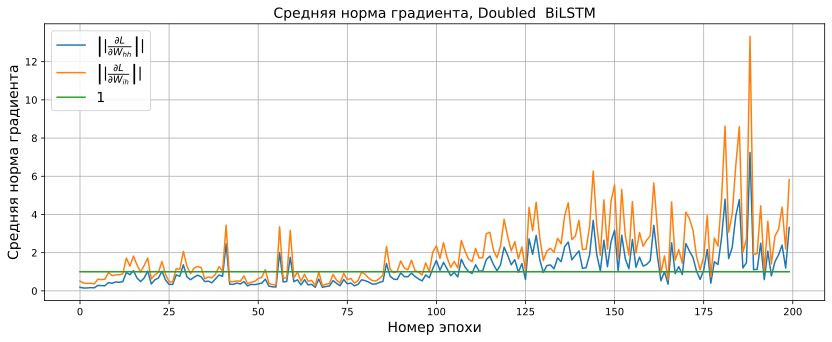

In [42]:
plot_grads(grad_history_BiLSTM, 'Doubled  BiLSTM')

In [43]:
for p in list(lstm.parameters()):
    print(p.shape)

torch.Size([400, 24])
torch.Size([400, 100])
torch.Size([400])
torch.Size([400])
torch.Size([400, 24])
torch.Size([400, 100])
torch.Size([400])
torch.Size([400])
torch.Size([400, 200])
torch.Size([400, 100])
torch.Size([400])
torch.Size([400])
torch.Size([400, 200])
torch.Size([400, 100])
torch.Size([400])
torch.Size([400])


Большая сложность модели привела к более гладкому обучению. Графики флуктуируют намного меньше, чем для обычной LSTM.

На данной задаче LSTM показала [SOTA качество](http://www.timeseriesclassification.com/results.php) (нужно учесть, что задача NATOPS максимально простая)

In [44]:
delete_model(model)
delete_model(lstm)

# `4. Тестирование 'памяти' рекуррентных нейронных сетей`

Для проверки способности вашей модели запоминать информацию на долгий период стандартно используется набор PSMNIST. ([Хотя он несколько подвергается критике](https://arxiv.org/pdf/1805.09733.pdf))

PermutedSequentialMNIST - датасет получаемый перестановкой пикселей в случайном порядке (фиксирован и един для всех картинок), причём полученый объект рассматривается как последовательность длины $28 \cdot 28$, с одномерной проекцией.

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.12MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 135kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.26MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.38MB/s]


(10000, 1, 28, 28)

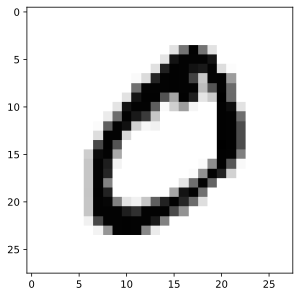

In [45]:
# Загрузка обычного MNIST
transform=T.Compose([
        T.ToTensor(),
        T.Normalize((0.1307,), (0.3081,))
        ])
train_dataset = torchvision.datasets.MNIST('../data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST('../data', train=False, download=True, transform=transform)

train_MNIST = torch.utils.data.DataLoader(train_dataset, batch_size = 10000)
test_MNIST = torch.utils.data.DataLoader(test_dataset, batch_size = 10000)

plt.imshow(next(iter(train_MNIST))[0][1][0].cpu().numpy(), cmap='Greys')
next(iter(train_MNIST))[0].cpu().numpy().shape

Для получения PSMNIST достаточно добавить преобразование перестановки пикселей. Отметим, что все преобразования делаются до перевода данных на GPU

In [46]:
class Image_permutation():
    """
    Перестановка пикселей в картинке
    """
    def __init__(self, c, h, w, permutation=None, flatten_flag=False):
        """
        c, h, w - параметры картинки
        permutation - перестановка, если None - генерируем новую
        flatten_flag - если False, то возвращаем объект вида c x h x w
                       если True, то c * h * w x 1
        """
        self.h = h
        self.w = w
        if permutation is not None:
            self.permutation = permutation
        else:
            self.permutation = torch.randperm(c * h*w)
        self.flatten_flag = flatten_flag

    def __call__(self, object):
        if self.flatten_flag:
            return object.flatten()[self.permutation].reshape(-1, 1)
        else:
            return object.flatten()[self.permutation].reshape((c, self.h, self.w))



(1000, 784, 1)

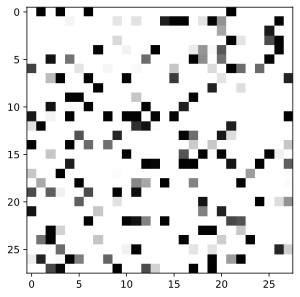

In [47]:
# Загрузка MNIST
transform=T.Compose([
        T.ToTensor(),
        T.Normalize((0.1307,), (0.3081,)),
        Image_permutation(1, 28, 28, flatten_flag=True) #Добавляем преобразование, переставляющее пиксели
        ])
train_dataset = torchvision.datasets.MNIST('../data', train=True, transform=transform)
test_dataset = torchvision.datasets.MNIST('../data', train=False, transform=transform)

train_PSMNIST = torch.utils.data.DataLoader(train_dataset, batch_size = 1000)
test_PSMNIST = torch.utils.data.DataLoader(test_dataset, batch_size = 1000)

plt.imshow(next(iter(train_PSMNIST))[0][1].cpu().numpy().reshape(28, 28), cmap='Greys')
next(iter(train_PSMNIST))[0].cpu().numpy().shape

Показательно, LSTM намного лучше обычной RNN в данном случае, чем при подаче картинки 'построчно'

In [48]:
def evaluate_torch(model, device, data_loader):
    """
    Возвращает качество и лосс модели на выборке
    Данные из dataloader приходят в tuple (data, target)
    """
    model.eval()
    loss = 0
    correct = 0
    length = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(data_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)

            # Обновляем качество
            loss += F.nll_loss(output, target).item()
            pred = output.argmax(dim=1)
            correct += (pred == target).sum().item()
            length += data.shape[0]

    return loss / length, correct / length


def train_torch(model, device, train_loader, test_loader, n_epoch, optimizer, scheduler,
          max_norm=None):
    """
    Обучение и оценивание качества на тесте одновременно
    Данные из dataloader приходят в tuple (data, target)
    """
    train_history, test_history = {'loss':[], 'acc':[]}, {'loss':[], 'acc':[]}

    for epoch in (pbar := tqdm(range(1, n_epoch + 1))):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            # Делаем шаг по батчу
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()

            # Gradient clipping
            if max_norm is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_norm)

            optimizer.step()
            scheduler.step()

        # Добавляем информацию
        loss, acc = evaluate_torch(model, device, train_loader)
        train_history['loss'].append(loss), train_history['acc'].append(acc)
        loss, acc = evaluate_torch(model, device, test_loader)
        test_history['loss'].append(loss), test_history['acc'].append(acc)
        pbar.set_description(f"Test accuracy {acc}")

    return train_history, test_history

In [49]:
class MNIST_LSTM_Classifier(nn.Module):
    def __init__(self, input_size, hidden_size, n_classes, rnn, activation, pixel_wise=False):
        super().__init__()
        self.pixel_wise = pixel_wise
        self.rnn = rnn

        # Классификатор - простой линейный слой
        self.classifier = nn.Sequential(
            nn.BatchNorm1d(hidden_size), nn.Linear(hidden_size, 32), activation, nn.Linear(32, n_classes)
        )

    def forward(self, input):

        # Размер входа в LSTM (N, L, M)
        if self.pixel_wise:
            # Наш ряд из Dataloader имеет представление (N, L, 1)
            1
        else:
            # Наш ряд из Dataloader имеет представление (N, С, H, W)
            N, L = input.shape[0], input.shape[2]
            input = input.reshape(N, L, -1)

        # Проход по LSTM
        output, hidden = self.rnn(input)

        # Размерность output (N, L, hidden)
        # Получаем h_L
        output = output[:, -1, :]

        # Проводим классификацию
        output = self.classifier(output)
        output = F.log_softmax(output, dim=1)
        return output

In [50]:
train_loader = train_PSMNIST
test_loader = test_PSMNIST

Обучим LSTM, GRU, RNN (Elman) и сравним их способность запоминать длинные последовательности.

In [51]:
from time import time

def get_exps_PSMNIST(rnn, in_size, h_size, pixel_wise=False, n_epoch=60, lr=5e-3):
    start = time()

    rnn = rnn(in_size, h_size, batch_first=True)
    model2 = MNIST_LSTM_Classifier(in_size, h_size, 10, rnn, nn.ReLU(), pixel_wise=pixel_wise).to(device)

    x, y = sum(p.numel() for p in rnn.parameters()), sum(p.numel() for p in model2.parameters())
    print(f'В модели {x} + {y - x} параметров')

    optimizer = optim.Adam(model2.parameters(), lr=lr)

    scheduler = StepLR(optimizer, step_size=100, gamma=0.9)

    train_history_LSTM, test_history_LSTM = train_torch(model2, device, train_loader, test_loader,
                                n_epoch, optimizer, scheduler)
    print('{} эпох обучались целых {:.2f} минут'.format(n_epoch, (time()-start)/60))

    delete_model(model2)
    delete_model(rnn)

    return train_history_LSTM, test_history_LSTM

In [52]:
train_history_LSTM, test_history_LSTM = get_exps_PSMNIST(nn.LSTM, 1, 52, pixel_wise=True, n_epoch=60, lr=3e-2)

В модели 11440 + 2130 параметров


  0%|          | 0/60 [00:00<?, ?it/s]

60 эпох обучались целых 31.23 минут


In [53]:
train_history_GRU, test_history_GRU = get_exps_PSMNIST(nn.GRU, 1, 60, pixel_wise=True, n_epoch=60)

В модели 11340 + 2402 параметров


  0%|          | 0/60 [00:00<?, ?it/s]

60 эпох обучались целых 30.45 минут


In [54]:
train_history_RNN, test_history_RNN = get_exps_PSMNIST(nn.RNN, 1, 100, pixel_wise=True, n_epoch=60)

В модели 10300 + 3762 параметров


  0%|          | 0/60 [00:00<?, ?it/s]

60 эпох обучались целых 29.66 минут


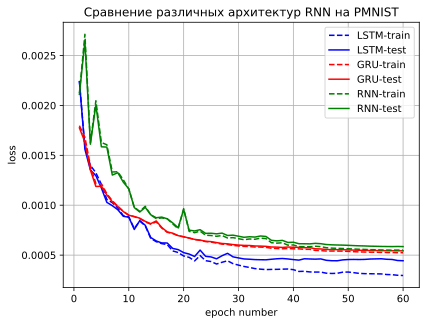

In [55]:
epochs = np.arange(60, dtype=int) + 1
plt.plot(epochs, train_history_LSTM['loss'], label='LSTM-train', c='b', linestyle='dashed')
plt.plot(epochs, test_history_LSTM['loss'], label='LSTM-test', c='b')
plt.plot(epochs, train_history_GRU['loss'], label='GRU-train', c='r', linestyle='dashed')
plt.plot(epochs, test_history_GRU['loss'], label='GRU-test', c='r')
plt.plot(epochs, train_history_RNN['loss'], label='RNN-train', c='g', linestyle='dashed')
plt.plot(epochs, test_history_RNN['loss'], label='RNN-test', c='g')
plt.grid()
plt.legend()
plt.ylabel('loss')
plt.xlabel('epoch number')
plt.title("Сравнение различных архитектур RNN на PMNIST")
plt.show()

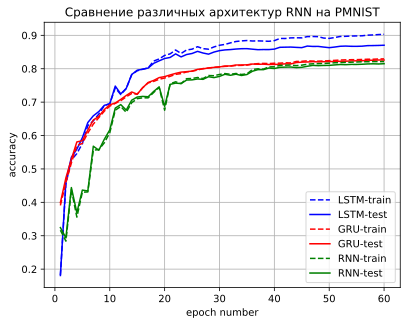

In [56]:
epochs = np.arange(60, dtype=int) + 1
plt.plot(epochs, train_history_LSTM['acc'], label='LSTM-train', c='b', linestyle='dashed')
plt.plot(epochs, test_history_LSTM['acc'], label='LSTM-test', c='b')
plt.plot(epochs, train_history_GRU['acc'], label='GRU-train', c='r', linestyle='dashed')
plt.plot(epochs, test_history_GRU['acc'], label='GRU-test', c='r')
plt.plot(epochs, train_history_RNN['acc'], label='RNN-train', c='g', linestyle='dashed')
plt.plot(epochs, test_history_RNN['acc'], label='RNN-test', c='g')
plt.grid()
plt.legend()
plt.ylabel('accuracy')
plt.xlabel('epoch number')
plt.title("Сравнение различных архитектур RNN на PMNIST")
plt.show()

Общее правило по использованию LSTM и GRU, полученное коммьюнити эмпирическим путем: последней рекуррентностью стоит использовать LSTM, а перед ней можно как и LSTM, так и GRU

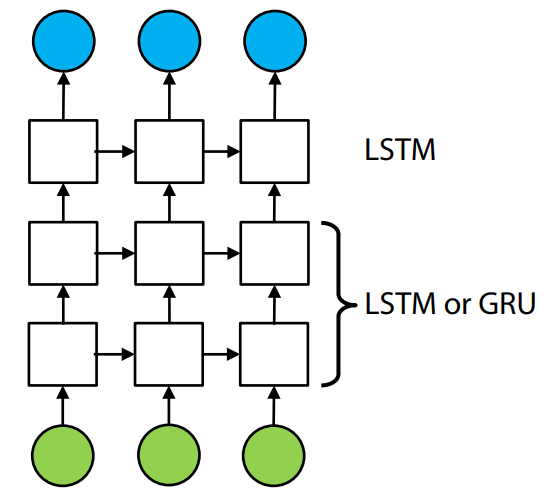

А теперь посмотрим как модели себя ведут на обычном MNIST

1. Длина последовательности $T = 28 = H$
2. Размерность проекции $M = 28 = W$

In [57]:
train_loader = train_MNIST
test_loader = test_MNIST

train_history_LSTM_MNIST, test_history_LSTM_MNIST = get_exps_PSMNIST(nn.LSTM, 28, 60, pixel_wise=False, n_epoch=20)

В модели 21600 + 2402 параметров


  0%|          | 0/20 [00:00<?, ?it/s]

20 эпох обучались целых 7.82 минут


In [58]:
train_history_GRU_MNIST, test_history_GRU_MNIST = get_exps_PSMNIST(nn.GRU, 28, 60, pixel_wise=False, n_epoch=20)

В модели 16200 + 2402 параметров


  0%|          | 0/20 [00:00<?, ?it/s]

20 эпох обучались целых 7.76 минут


In [59]:
train_history_RNN_MNIST, test_history_RNN_MNIST = get_exps_PSMNIST(nn.RNN, 28, 110, pixel_wise=False, n_epoch=20)

В модели 15400 + 4102 параметров


  0%|          | 0/20 [00:00<?, ?it/s]

20 эпох обучались целых 7.85 минут


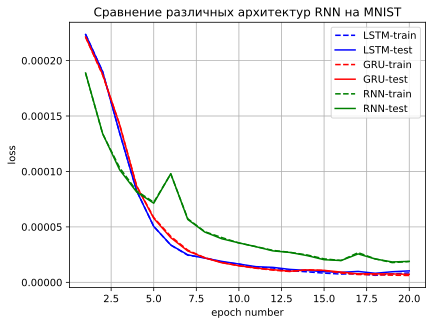

In [60]:
epochs = np.arange(20, dtype=int) + 1
plt.plot(epochs, train_history_LSTM_MNIST['loss'], label='LSTM-train', c='b', linestyle='dashed')
plt.plot(epochs, test_history_LSTM_MNIST['loss'], label='LSTM-test', c='b')
plt.plot(epochs, train_history_GRU_MNIST['loss'], label='GRU-train', c='r', linestyle='dashed')
plt.plot(epochs, test_history_GRU_MNIST['loss'], label='GRU-test', c='r')
plt.plot(epochs, train_history_RNN_MNIST['loss'], label='RNN-train', c='g', linestyle='dashed')
plt.plot(epochs, test_history_RNN_MNIST['loss'], label='RNN-test', c='g')
plt.grid()
plt.legend()
plt.ylabel('loss')
plt.xlabel('epoch number')
plt.title("Сравнение различных архитектур RNN на MNIST")
plt.show()

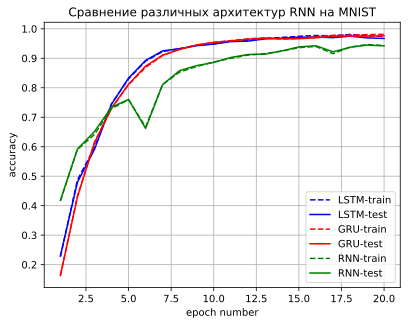

In [61]:
epochs = np.arange(20, dtype=int) + 1
plt.plot(epochs, train_history_LSTM_MNIST['acc'], label='LSTM-train', c='b', linestyle='dashed')
plt.plot(epochs, test_history_LSTM_MNIST['acc'], label='LSTM-test', c='b')
plt.plot(epochs, train_history_GRU_MNIST['acc'], label='GRU-train', c='r', linestyle='dashed')
plt.plot(epochs, test_history_GRU_MNIST['acc'], label='GRU-test', c='r')
plt.plot(epochs, train_history_RNN_MNIST['acc'], label='RNN-train', c='g', linestyle='dashed')
plt.plot(epochs, test_history_RNN_MNIST['acc'], label='RNN-test', c='g')
plt.grid()
plt.legend()
plt.ylabel('accuracy')
plt.xlabel('epoch number')
plt.title("Сравнение различных архитектур RNN на MNIST")
plt.show()

Действительно, даже для таких длинных последовательностей наши модели оказались применимы, что говорит о том, что с памятью у них все в порядке. Отметим, что время обучения на PSMNIST в 2 раза привысило время обучения на MNIST. Это вызвано недостатком памяти GPU. Другая проблема заключается в постоянном использовании питоновских циклов при проходе по RNN - отсутствии параллельности. Этот аспект в целом является главной проблемой рекуррентных сетей.

Рассмотрим следующую таблицу, сравнивающую теоретическую эффективность моделей, работающих с последовательностями. Приводится в статье [модель S4](https://arxiv.org/pdf/2111.00396.pdf).

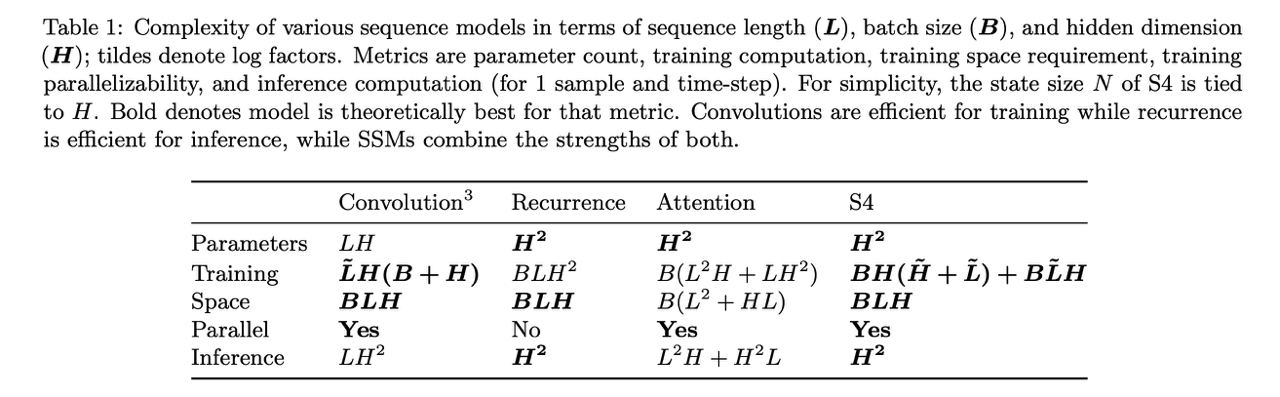

Вывод в рекуррентной модели на каждом шаге производится за $H^2$, т.е. не зависит от длины последовательности.

Время обучения также асимптотически линейно от длины последовательности. Однако нужно понимать, что в данном случае скорость RNN по длине является скоростью перехода по питоновским циклам, а для свёрточной сети связана с длиной свёртки, т.е. в первом случае отсутсвует возможность параллельного вычисления. Поэтому на практике при большой длине L RNN сильно уступает в скорости свёрточной модели на этапе обучения (в качестве примера сверточной архитектуры для обработки последовательностей рекомендуется посмотреть [InceptionTime](https://arxiv.org/pdf/1909.04939.pdf). Более того, современные архитектуры на основе механизма внимания также могут учиться быстрее рекуррентных сетей за счет параллельности и эффективной реализации ([FlashAttentionV2](https://arxiv.org/abs/2307.08691). Однако, для сверхбольших последовательностей и этого уже недостаточно, и человечество разработало новый подход, выраженный в лице [модели S4](https://arxiv.org/pdf/2111.00396.pdf) и [Mamba](https://arxiv.org/pdf/2312.00752.pdf). Но в прошлом году появилась статья, которая говорит о том, что в таких задачах RNN [тоже могут быть конкурентноспособны](https://arxiv.org/pdf/2303.06349.pdf), однако, на задачах из этого ноутбука LRU не завелась в нормальном виде.

Ссылки на некоторые материалы:

[Полный разбор LSTM и RNN с их градиентами.](https://arxiv.org/pdf/1808.03314.pdf)

Также при подготовке к данному семинару использовались следующие открытые источника:

https://mmuratarat.github.io/2019-02-07/bptt-of-rnn

https://github.com/amanchadha/coursera-deep-learning-specialization/tree/master/C5%20-%20Sequence%20Models